In [1]:
import os, json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DK68_DIR   = Path("/Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed/network_sindy_out_DK68")
SCH100_DIR = Path("/Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed/network_sindy_out_Sch100")
SCH200_DIR = Path("/Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed/network_sindy_out_Sch200")

RUNS = {
    "DK68": DK68_DIR,
    "Sch100": SCH100_DIR,
    "Sch200": SCH200_DIR,
}

FIG_DIR = Path("/Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed/figures_compare_parcellations")
FIG_DIR.mkdir(parents=True, exist_ok=True)

def read_json(p: Path):
    if not p.exists():
        return None
    with open(p, "r") as f:
        return json.load(f)


In [2]:
def find_first(root: Path, patterns):
    """Return first match for any glob pattern (recursive)."""
    for pat in patterns:
        hits = list(root.rglob(pat))
        if hits:
            # deterministic: sort by path length then name
            hits = sorted(hits, key=lambda x: (len(str(x)), str(x)))
            return hits[0]
    return None

FILE_PATTERNS = {
    "Xi_best": ["Xi_best.npy", "*Xi_best*.npy"],
    "W_hat":   ["W_hat.npy", "*W_hat*.npy", "*What*.npy"],
    "metrics": ["metrics_best.json", "sweep_metrics.json", "*metrics*.json"],
    "cfg":     ["cfg.json", "*cfg*.json", "*config*.json"],
}

def discover_run_files(run_dir: Path):
    files = {}
    for k, pats in FILE_PATTERNS.items():
        files[k] = find_first(run_dir, pats)
    return files


In [3]:
def nnz_count(X, tol=1e-12):
    return int(np.sum(np.abs(X) > tol))

def load_one(parc: str, run_dir: Path):
    files = discover_run_files(run_dir)
    Xi_path = files["Xi_best"]
    if Xi_path is None:
        raise FileNotFoundError(f"[{parc}] Could not find Xi_best.npy under: {run_dir}")

    Xi = np.load(Xi_path)

    # optional files
    W_hat = np.load(files["W_hat"]) if files["W_hat"] else None
    metrics = read_json(files["metrics"]) if files["metrics"] else {}
    cfg = read_json(files["cfg"]) if files["cfg"] else {}

    # compute a few always-available things
    N, P = Xi.shape
    row_nnz = (np.abs(Xi) > 1e-12).sum(axis=1)

    out = {
        "parcellation": parc,
        "run_dir": str(run_dir),
        "Xi_path": str(Xi_path),
        "N": N,
        "n_features": P,
        "nnz_total": nnz_count(Xi),
        "nnz_per_node_mean": float(row_nnz.mean()),
        "nnz_per_node_std": float(row_nnz.std()),
    }

    # Merge in whatever you saved
    # (these keys are flexible; we just “try” common ones)
    def pick(d, *keys):
        for k in keys:
            if k in d:
                return d[k]
        return None

    out["best_lambda"] = pick(metrics, "best_lambda", "lam_best", "lambda_best", "lam")
    out["best_tau_samples"] = pick(metrics, "best_tau_samples", "tau_best", "tau_samples", "tau")
    out["val_mse"] = pick(metrics, "val_mse", "val_mse_mean", "val_error")
    out["train_mse"] = pick(metrics, "train_mse", "train_mse_mean", "train_error")
    out["rollout_rmse_val"] = pick(metrics, "rollout_rmse_val", "val_rollout_rmse", "rollout_rmse")
    out["stable"] = pick(metrics, "stable", "is_stable", "stability_ok")

    # store arrays for optional later analysis
    out["_Xi"] = Xi
    out["_W_hat"] = W_hat
    out["_metrics_raw"] = metrics
    out["_cfg_raw"] = cfg
    return out

results = []
for parc, d in RUNS.items():
    res = load_one(parc, d)
    results.append(res)

# Make a clean dataframe (drop big arrays)
df = pd.DataFrame([{k:v for k,v in r.items() if not k.startswith("_")} for r in results])
df


,parcellation,run_dir,Xi_path,N,n_features,nnz_total,nnz_per_node_mean,nnz_per_node_std,best_lambda,best_tau_samples,val_mse,train_mse,rollout_rmse_val,stable
0,DK68,/Users/apple/Documents/Computational Neuroscie...,/Users/apple/Documents/Computational Neuroscie...,68,71,1248,18.352941,5.903052,0.000100,2,0.041056,0.032486,NaN,True
1,Sch100,/Users/apple/Documents/Computational Neuroscie...,/Users/apple/Documents/Computational Neuroscie...,100,103,1513,15.130000,5.021265,0.000100,0,0.076983,0.017627,NaN,True
2,Sch200,/Users/apple/Documents/Computational Neuroscie...,/Users/apple/Documents/Computational Neuroscie...,200,203,3062,15.310000,6.068270,0.000316,2,0.060690,0.012428,NaN,True


In [4]:
for r in results:
    parc = r["parcellation"]
    Xi = r["_Xi"]
    N, P = Xi.shape
    # For your standard library: P should be 3 + N (const, x, x^3, N network terms)
    # If you used different toggles, this may differ; treat as warning not failure.
    expected = 3 + N
    if P != expected:
        print(f"[WARN] {parc}: Xi has shape {Xi.shape}, expected ~({N},{expected}) if using (1, x, x^3, N network terms).")
    else:
        print(f"[OK] {parc}: Xi shape {Xi.shape}")


[OK] DK68: Xi shape (68, 71)
[OK] Sch100: Xi shape (100, 103)
[OK] Sch200: Xi shape (200, 203)


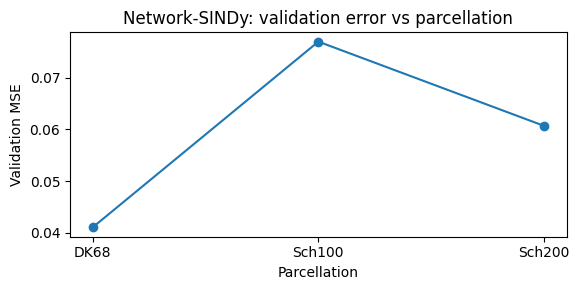

Saved: /Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed/figures_compare_parcellations/val_mse.png


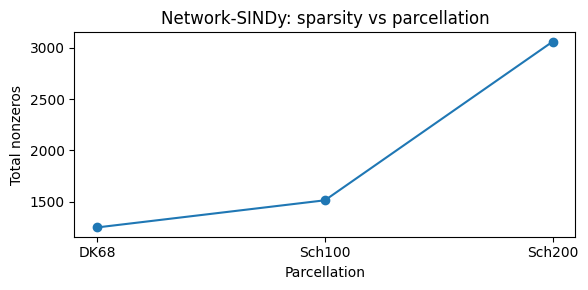

Saved: /Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed/figures_compare_parcellations/nnz_total.png


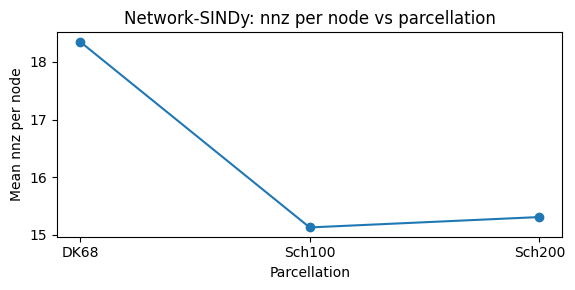

Saved: /Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed/figures_compare_parcellations/nnz_per_node_mean.png


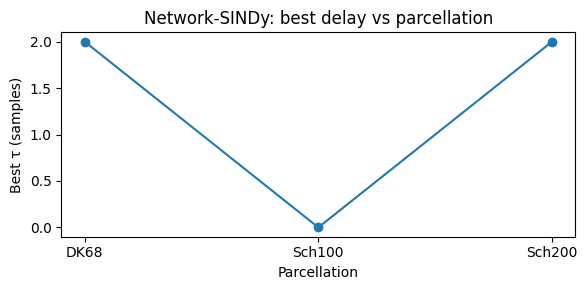

Saved: /Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed/figures_compare_parcellations/best_tau_samples.png


In [5]:
def plot_metric(metric, ylabel=None, title=None, rotate=0):
    x = df["parcellation"]
    y = df[metric]
    plt.figure(figsize=(6,3))
    plt.plot(x, y, "o-")
    plt.xlabel("Parcellation")
    plt.ylabel(ylabel or metric)
    plt.title(title or metric)
    plt.xticks(rotation=rotate)
    plt.tight_layout()
    out = FIG_DIR / f"{metric}.png"
    plt.savefig(out, dpi=200)
    plt.show()
    print("Saved:", out)

# These will work if present; otherwise you’ll see NaNs (still fine)
plot_metric("val_mse", ylabel="Validation MSE", title="Network-SINDy: validation error vs parcellation")
plot_metric("nnz_total", ylabel="Total nonzeros", title="Network-SINDy: sparsity vs parcellation")
plot_metric("nnz_per_node_mean", ylabel="Mean nnz per node", title="Network-SINDy: nnz per node vs parcellation")
plot_metric("best_tau_samples", ylabel="Best τ (samples)", title="Network-SINDy: best delay vs parcellation")


In [6]:
for parc, d in RUNS.items():
    files = discover_run_files(d)
    print("\n===", parc, "===")
    for k,v in files.items():
        print(f"{k:>8}:", v)



=== DK68 ===
 Xi_best: /Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed/network_sindy_out_DK68/Xi_best.npy
   W_hat: /Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed/network_sindy_out_DK68/W_hat.npy
 metrics: /Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed/network_sindy_out_DK68/metrics_best.json
     cfg: /Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed/network_sindy_out_DK68/config_network_sindy_DK68_hopf_2025-12-30_154030.json

=== Sch100 ===
 Xi_best: /Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed/network_sindy_out_Sch100/Xi_best.npy
   W_hat: /Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed/network_sindy_out_Sch100/W_hat.npy
 met